<a href="https://colab.research.google.com/github/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/CRNN_CTC_wandb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade wandb

     |████████████████████████████████| 1.4MB 3.5MB/s 
     |████████████████████████████████| 102kB 8.2MB/s 
     |████████████████████████████████| 163kB 17.3MB/s 
     |████████████████████████████████| 122kB 17.4MB/s 
     |████████████████████████████████| 102kB 8.2MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=046a5b0d9199d846606de02eeccfa5ab6c51db2eec6f454b19c8abde07aa56e7
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=3025d418e2ce4f6cc48308953b76ed2d3d978e655ef06627dae1b0752d152261
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=ef31

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import cv2
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby


import wandb
from wandb.keras import WandbCallback

In [3]:
tf.__version__

'2.3.0'

In [4]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
!unzip -qq /content/drive/My\ Drive/mjsynth_sample.zip

In [10]:
image_paths = []
image_texts = []

data_folder = "mjsynth_sample"

for path in os.listdir(data_folder):
    image_paths.append(data_folder + "/" + path)
    image_texts.append(path.split("_")[1])

In [11]:
image_paths[:10], image_texts[:10]

(['mjsynth_sample/285_maximally_47253.jpg',
  'mjsynth_sample/17_SADDLED_67309.jpg',
  'mjsynth_sample/489_scandinavia_68113.jpg',
  'mjsynth_sample/153_Prided_60045.jpg',
  'mjsynth_sample/161_Yiddish_87785.jpg',
  'mjsynth_sample/282_wittering_86950.jpg',
  'mjsynth_sample/400_foreknows_30204.jpg',
  'mjsynth_sample/123_Twig_81383.jpg',
  'mjsynth_sample/275_POLAROIDS_58553.jpg',
  'mjsynth_sample/419_Castigation_11894.jpg'],
 ['maximally',
  'SADDLED',
  'scandinavia',
  'Prided',
  'Yiddish',
  'wittering',
  'foreknows',
  'Twig',
  'POLAROIDS',
  'Castigation'])

In [12]:
corrupt_images = []

for path in image_paths:
    try:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    except:
        corrupt_images.append(path)

In [13]:
corrupt_images, len(corrupt_images)

(['mjsynth_sample/458_DEVILS_21283.jpg'], 1)

In [14]:
for path in corrupt_images:
    
    corrupt_index = image_paths.index(path)
    del image_paths[corrupt_index]
    del image_texts[corrupt_index]


In [15]:
### get vocabulary for the current dataset
vocab = set("".join(map(str, image_texts)))
print(sorted(vocab))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [16]:
max_label_len = max([len(str(text)) for text in image_texts])
max_label_len

23

In [17]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
    
    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list))[0]
    

In [18]:
padded_image_texts = list(map(encode_to_labels, image_texts))

padded_image_texts[0]

array([48, 36, 59, 44, 48, 36, 47, 47, 60, 62, 62, 62, 62, 62, 62, 62, 62,
       62, 62, 62, 62, 62, 62], dtype=int32)

In [19]:
train_image_paths = image_paths[ : int(len(image_paths) * 0.90)]
train_image_texts = padded_image_texts[ : int(len(image_texts) * 0.90)]

val_image_paths = image_paths[int(len(image_paths) * 0.90) : ]
val_image_texts = padded_image_texts[int(len(image_texts) * 0.90) : ]

In [20]:
def process_single_sample(img_path, label):

    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)

    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [32, 128])

    return {"image": img, "label": label}

In [21]:
process_single_sample('mjsynth_sample/362_interpreter_40330.jpg', [1,2,3,4])

{'image': <tf.Tensor: shape=(32, 128, 1), dtype=float32, numpy=
 array([[[0.76470596],
         [0.7648285 ],
         [0.7686275 ],
         ...,
         [0.76691186],
         [0.7725491 ],
         [0.766054  ]],
 
        [[0.76470596],
         [0.7648285 ],
         [0.7686275 ],
         ...,
         [0.7695983 ],
         [0.7725491 ],
         [0.7697917 ]],
 
        [[0.76470596],
         [0.7648285 ],
         [0.7686275 ],
         ...,
         [0.7687137 ],
         [0.7654317 ],
         [0.76749015]],
 
        ...,
 
        [[0.7595493 ],
         [0.7822879 ],
         [0.77083343],
         ...,
         [0.7686275 ],
         [0.7648285 ],
         [0.76470596]],
 
        [[0.7597408 ],
         [0.7607231 ],
         [0.770282  ],
         ...,
         [0.76857585],
         [0.7648228 ],
         [0.76452214]],
 
        [[0.7659314 ],
         [0.7495098 ],
         [0.7590687 ],
         ...,
         [0.7675246 ],
         [0.76470596],
         [0.76078

In [22]:
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_texts))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_texts))
validation_dataset = (
    validation_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [23]:
wandb.init(entity="authors", project="text-recognition-crnn-ctc", name="log_images")

W&B Run: https://app.wandb.ai/authors/text-recognition-crnn-ctc/runs/1x2aiorx

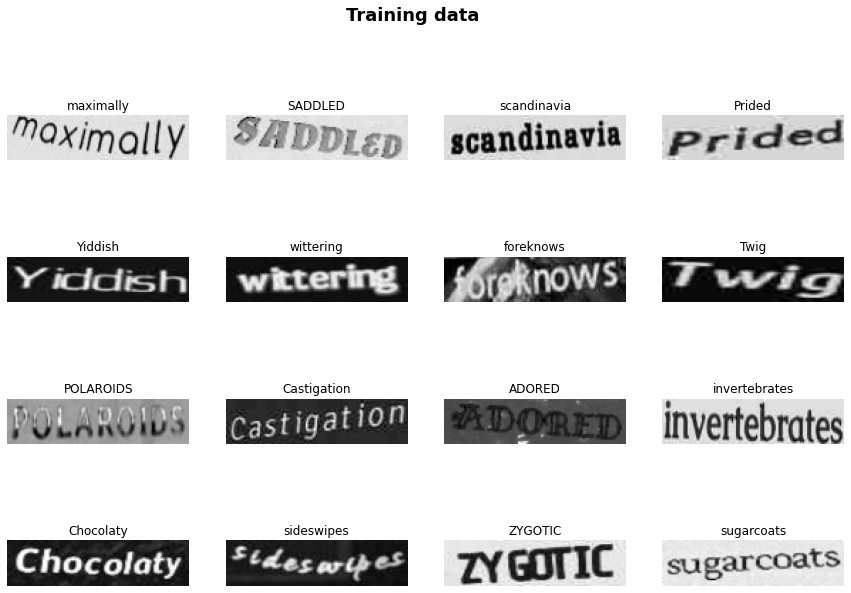

In [24]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_list, num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

train_data_fig, ax = plt.subplots(4, 4, figsize=(15, 10))
train_data_fig.suptitle('Training data', weight='bold', size=18)


for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]

    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")

        label = label.replace('[UNK]', '')
        ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
    
plt.show()


wandb.log({"train_data": train_data_fig})

In [25]:
## Ref: https://keras.io/examples/vision/captcha_ocr/

class CTCLayer(layers.Layer):

    def __init__(self, name=None):

        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [26]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(char_list):
                ans += char_list[int(p)]
        
        text_list.append(ans)
        
    return text_list

In [27]:
figures_list = []

class PlotPredictions(tf.keras.callbacks.Callback):

    def __init__(self, frequency=1):
        self.frequency = frequency
        super(PlotPredictions, self).__init__()

        batch = validation_dataset.take(1)
        self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
        self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

    def plot_predictions(self, epoch):

        prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, 
            self.model.get_layer(name="dense").output
        )
        
        preds = prediction_model.predict(self.batch_images)
        pred_texts = ctc_decoder(preds)

        orig_texts = []

        for label in self.batch_labels:
            orig_texts.append("".join([char_list[int(char_ind)] for char_ind in label if not(char_ind == len(char_list))]))

        fig , ax = plt.subplots(4, 4, figsize=(15, 5))
        fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

        for i in range(16):

            img = (self.batch_images[i, :, :, 0] * 255).astype(np.uint8)
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
        
        plt.show()
        #plt.savefig("predictions_epoch_"+ str(epoch)+'.png', bbox_inches = 'tight', pad_inches = 0)
        
        figures_list.append(fig)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            self.plot_predictions(epoch)


In [28]:
def train(epochs):
    
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(32, 128, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(conv_3)

    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)


    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    #model to be used at training time
    model = Model(inputs=[inputs, labels], outputs=output)
    model.compile(optimizer = optimizer)

    print(model.summary())
    file_path = "C_LSTM_best.hdf5"
    
    checkpoint = ModelCheckpoint(filepath=file_path, 
                                monitor='val_loss', 
                                verbose=1, 
                                save_best_only=True, 
                                mode='min')

    callbacks_list = [checkpoint, 
                      WandbCallback(monitor="val_loss", 
                                    mode="min", 
                                    log_weights=True),
                      PlotPredictions(frequency=1),
                      EarlyStopping(patience=3, verbose=1)]

    history = model.fit(train_dataset, 
                        epochs = epochs,
                        validation_data=validation_dataset,
                        verbose = 1,
                        callbacks = callbacks_list,
                        shuffle=True)
    
    return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 32, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 128, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 64, 64)   18496       max_pooling2d[0][0]              
_______________________________________________________________________________________

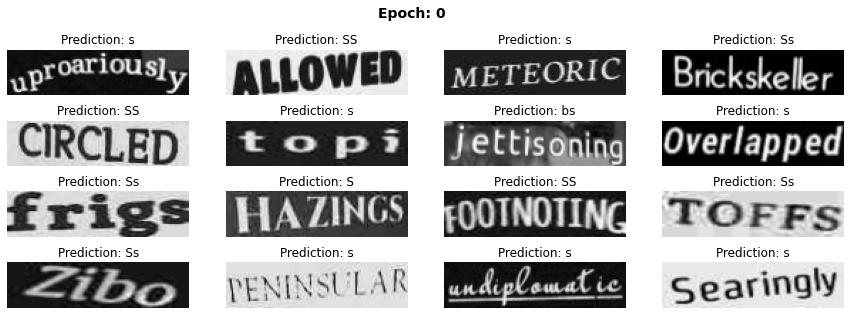

186/186 [==============================] - 95s 508ms/step - loss: 30.1328 - val_loss: 29.2381
Epoch 2/30
186/186 [==============================] - ETA: 0s - loss: 26.5249
Epoch 00002: val_loss improved from 29.23813 to 25.54404, saving model to C_LSTM_best.hdf5


<Figure size 432x288 with 0 Axes>

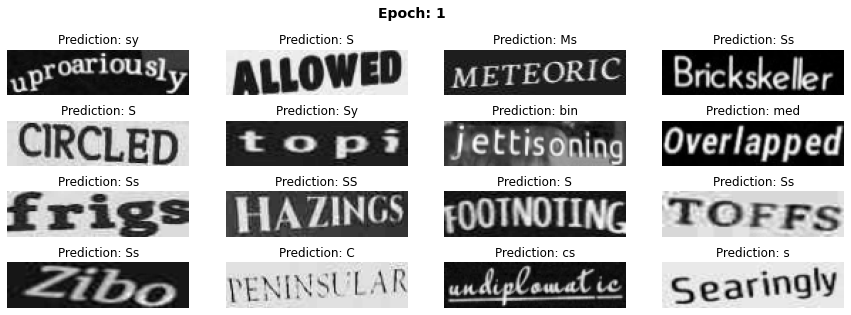

186/186 [==============================] - 93s 502ms/step - loss: 26.5249 - val_loss: 25.5440
Epoch 3/30
186/186 [==============================] - ETA: 0s - loss: 21.8941
Epoch 00003: val_loss improved from 25.54404 to 20.43891, saving model to C_LSTM_best.hdf5


<Figure size 432x288 with 0 Axes>

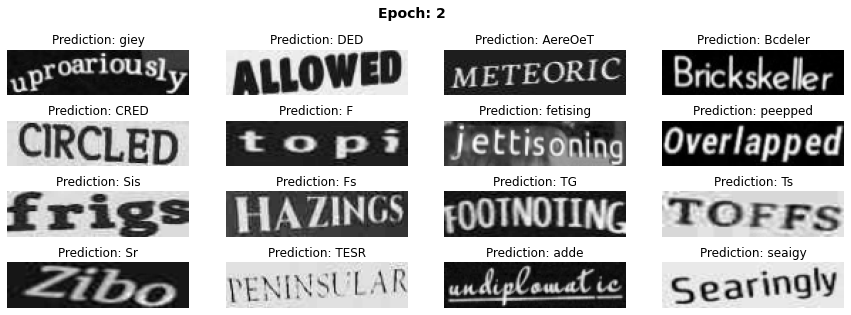

186/186 [==============================] - 94s 506ms/step - loss: 21.8941 - val_loss: 20.4389
Epoch 4/30
186/186 [==============================] - ETA: 0s - loss: 12.7605
Epoch 00004: val_loss improved from 20.43891 to 11.75495, saving model to C_LSTM_best.hdf5


<Figure size 432x288 with 0 Axes>

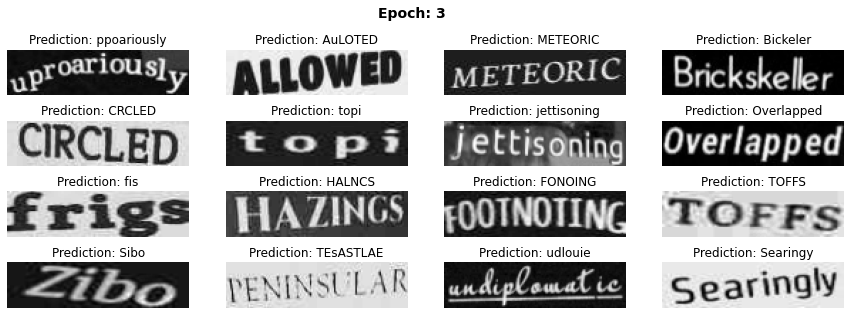

186/186 [==============================] - 94s 503ms/step - loss: 12.7605 - val_loss: 11.7550
Epoch 5/30
186/186 [==============================] - ETA: 0s - loss: 7.8759
Epoch 00005: val_loss improved from 11.75495 to 7.83686, saving model to C_LSTM_best.hdf5


<Figure size 432x288 with 0 Axes>

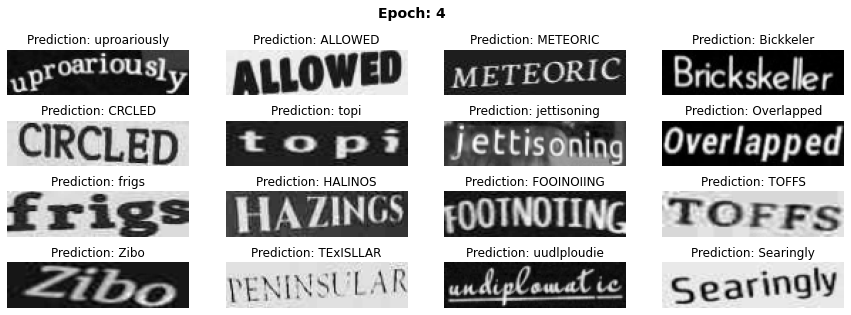

186/186 [==============================] - 93s 500ms/step - loss: 7.8759 - val_loss: 7.8369
Epoch 6/30
186/186 [==============================] - ETA: 0s - loss: 6.0581
Epoch 00006: val_loss improved from 7.83686 to 7.53775, saving model to C_LSTM_best.hdf5


<Figure size 432x288 with 0 Axes>

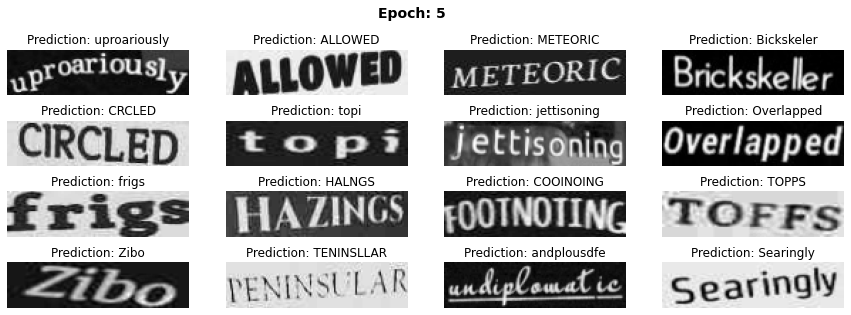

186/186 [==============================] - 94s 507ms/step - loss: 6.0581 - val_loss: 7.5378
Epoch 7/30
186/186 [==============================] - ETA: 0s - loss: 5.1183
Epoch 00007: val_loss improved from 7.53775 to 6.72885, saving model to C_LSTM_best.hdf5


<Figure size 432x288 with 0 Axes>

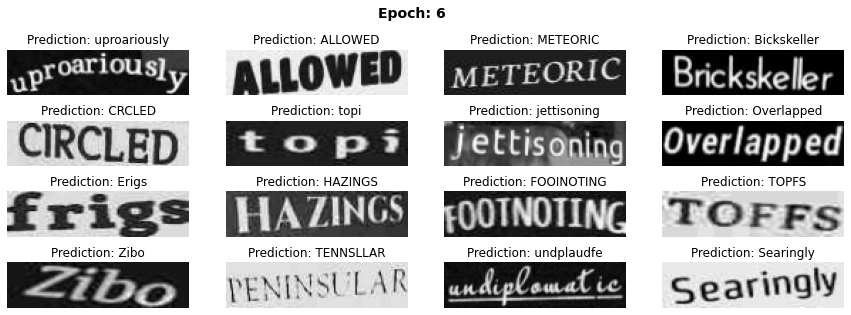

186/186 [==============================] - 92s 496ms/step - loss: 5.1183 - val_loss: 6.7288
Epoch 8/30
186/186 [==============================] - ETA: 0s - loss: 4.4831
Epoch 00008: val_loss did not improve from 6.72885


<Figure size 432x288 with 0 Axes>

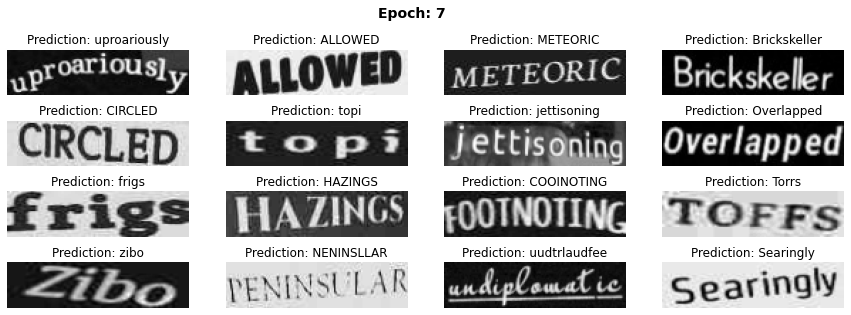

186/186 [==============================] - 92s 496ms/step - loss: 4.4831 - val_loss: 7.0536
Epoch 9/30
186/186 [==============================] - ETA: 0s - loss: 3.9917
Epoch 00009: val_loss improved from 6.72885 to 5.77833, saving model to C_LSTM_best.hdf5


<Figure size 432x288 with 0 Axes>

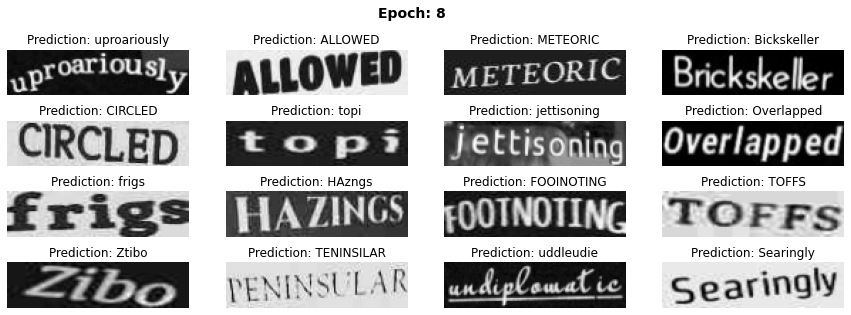

186/186 [==============================] - 94s 505ms/step - loss: 3.9917 - val_loss: 5.7783
Epoch 10/30
186/186 [==============================] - ETA: 0s - loss: 3.6267
Epoch 00010: val_loss improved from 5.77833 to 5.62654, saving model to C_LSTM_best.hdf5


<Figure size 432x288 with 0 Axes>

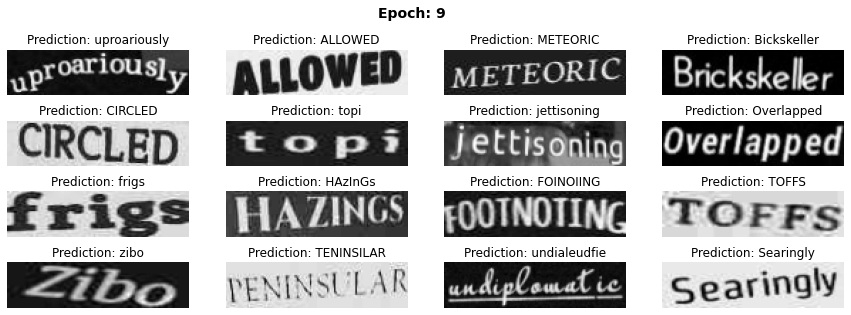

186/186 [==============================] - 94s 503ms/step - loss: 3.6267 - val_loss: 5.6265
Epoch 11/30
186/186 [==============================] - ETA: 0s - loss: 3.3249
Epoch 00011: val_loss did not improve from 5.62654


<Figure size 432x288 with 0 Axes>

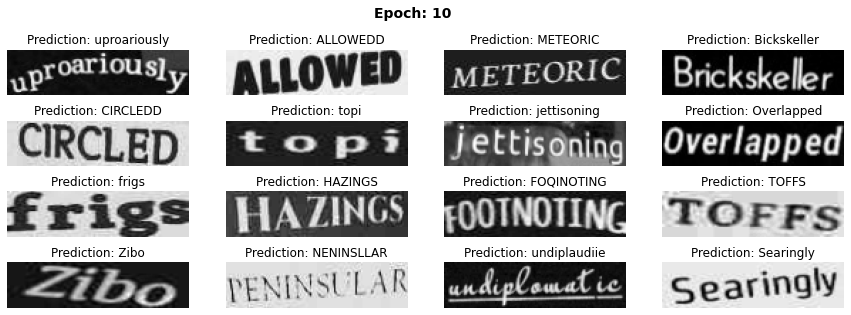

186/186 [==============================] - 91s 489ms/step - loss: 3.3249 - val_loss: 5.8698
Epoch 12/30
186/186 [==============================] - ETA: 0s - loss: 3.0401
Epoch 00012: val_loss improved from 5.62654 to 5.50746, saving model to C_LSTM_best.hdf5


<Figure size 432x288 with 0 Axes>

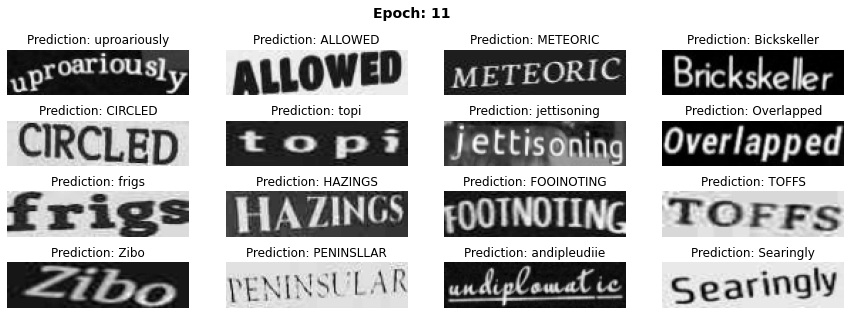

186/186 [==============================] - 94s 506ms/step - loss: 3.0401 - val_loss: 5.5075
Epoch 13/30
186/186 [==============================] - ETA: 0s - loss: 2.7644
Epoch 00013: val_loss did not improve from 5.50746


<Figure size 432x288 with 0 Axes>

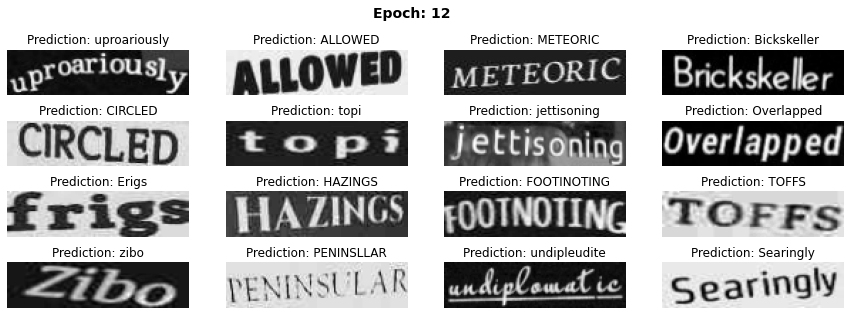

186/186 [==============================] - 92s 494ms/step - loss: 2.7644 - val_loss: 5.7367
Epoch 14/30
186/186 [==============================] - ETA: 0s - loss: 2.5616
Epoch 00014: val_loss did not improve from 5.50746


<Figure size 432x288 with 0 Axes>

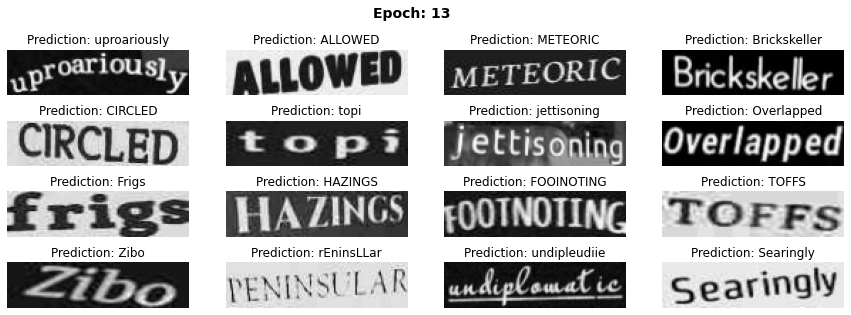

186/186 [==============================] - 91s 487ms/step - loss: 2.5616 - val_loss: 5.9098
Epoch 15/30
186/186 [==============================] - ETA: 0s - loss: 2.3504
Epoch 00015: val_loss did not improve from 5.50746


<Figure size 432x288 with 0 Axes>

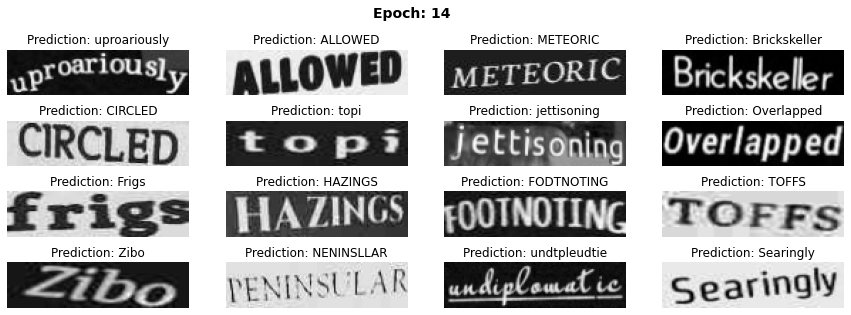

186/186 [==============================] - 93s 503ms/step - loss: 2.3504 - val_loss: 5.6839
Epoch 00015: early stopping


<Figure size 432x288 with 0 Axes>

In [29]:
model = train(epochs=30)

In [30]:
model.load_weights('C_LSTM_best.hdf5')

In [31]:

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense").output
)
prediction_model.summary()




Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 128)        73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 128)      

In [32]:
len(figures_list)

15

In [33]:
wandb.log({"prediction_for_each_epoch": [wandb.Image(fig, caption="epoch_"+str(i)) for i, fig in enumerate(figures_list)]})

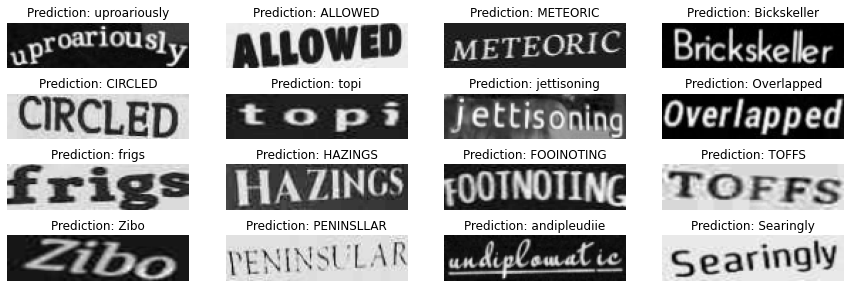

In [34]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):

    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = ctc_decoder(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    fig , ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(16):

        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
        
plt.show()


In [35]:
wandb.log({"prediction_best_epoch": fig})

In [ ]:
## results can be improved with finetuning and including more data :)